<a href="https://colab.research.google.com/github/Redcoder815/Deep_Learning_Python/blob/main/multilayerperceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# function INIT(layer_sizes, activation):
#     num_layers = length(layer_sizes) - 1

#     for each layer i:
#         initialize weight matrix W[i] with random values
#         initialize bias vector b[i] with zeros

#     choose activation function and its derivative

# function FORWARD(X):
#     activations = [X]
#     preactivations = []

#     for each hidden layer i:
#         z = activations[i] * W[i] + b[i]
#         a = activation(z)
#         store z and a

#     # Output layer uses softmax
#     z_last = last_activation * W_last + b_last
#     a_last = softmax(z_last)

#     return activations, preactivations

# function BACKWARD(activations, preactivations, y_true):
#     convert y_true to one-hot encoding

#     # Output layer gradient
#     delta = (softmax_output - one_hot_labels) / batch_size

#     for each layer i from last to first:
#         grad_W[i] = activations[i]^T * delta
#         grad_B[i] = sum(delta over batch)

#         if not first layer:
#             delta = (delta * W[i]^T) * activation_derivative(preactivations[i-1])

#     return grad_W, grad_B

# function UPDATE(grad_W, grad_B, learning_rate):
#     for each layer i:
#         W[i] = W[i] - learning_rate * grad_W[i]
#         B[i] = B[i] - learning_rate * grad_B[i]

# function LOSS(X, y):
#     compute forward pass to get probabilities
#     extract probability of correct class for each sample
#     compute mean negative log likelihood
#     return loss

# function FIT(X, y, epochs, learning_rate, batch_size):

#     for epoch in range(epochs):

#         shuffle dataset

#         for each batch:
#             X_batch, y_batch = next batch

#             activations, preactivations = FORWARD(X_batch)
#             grad_W, grad_B = BACKWARD(activations, preactivations, y_batch)
#             UPDATE(grad_W, grad_B, learning_rate)

#         optionally print loss every N epochs

# function PREDICT(X):
#     compute forward pass
#     return index of max probability for each sample



import numpy as np

# -----------------------------
# Activation functions
# -----------------------------
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

# -----------------------------
# MLP Class
# -----------------------------
class MLP:
    def __init__(self, layer_sizes, activation="relu", seed=42):
        """
        layer_sizes: list like [input_dim, hidden1, hidden2, ..., output_dim]
        activation: "relu" or "sigmoid"
        """
        np.random.seed(seed)

        self.num_layers = len(layer_sizes) - 1
        self.weights = []
        self.biases = []

        # Initialize weights
        for i in range(self.num_layers):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)

        # Activation choice
        if activation == "relu":
            self.activation = relu
            self.activation_derivative = relu_derivative
        else:
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative

    # -----------------------------
    # Forward pass
    # -----------------------------
    def forward(self, X):
        a = X
        activations = [X]
        zs = []

        for i in range(self.num_layers - 1):
            z = a @ self.weights[i] + self.biases[i]
            a = self.activation(z)
            zs.append(z)
            activations.append(a)

        # Output layer (softmax)
        z = activations[-1] @ self.weights[-1] + self.biases[-1]
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        a = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        zs.append(z)
        activations.append(a)

        return activations, zs

    # -----------------------------
    # Backpropagation
    # -----------------------------
    def backward(self, activations, zs, y_true):
        m = y_true.shape[0]
        grads_w = [None] * self.num_layers
        grads_b = [None] * self.num_layers

        # One-hot encode labels
        y_onehot = np.zeros_like(activations[-1])
        y_onehot[np.arange(m), y_true] = 1

        # Output layer gradient
        delta = (activations[-1] - y_onehot) / m

        # Backprop through layers
        for i in reversed(range(self.num_layers)):
            grads_w[i] = activations[i].T @ delta
            grads_b[i] = np.sum(delta, axis=0, keepdims=True)

            if i > 0:
                delta = (delta @ self.weights[i].T) * self.activation_derivative(zs[i-1])

        return grads_w, grads_b

    # -----------------------------
    # Parameter update
    # -----------------------------
    def update(self, grads_w, grads_b, lr):
        for i in range(self.num_layers):
            self.weights[i] -= lr * grads_w[i]
            self.biases[i] -= lr * grads_b[i]

    # -----------------------------
    # Training loop
    # -----------------------------
    def fit(self, X, y, epochs=1000, lr=0.01, batch_size=32):
        n = X.shape[0]

        for epoch in range(epochs):
            idx = np.random.permutation(n)
            X_shuffled = X[idx]
            y_shuffled = y[idx]

            for start in range(0, n, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                activations, zs = self.forward(X_batch)
                grads_w, grads_b = self.backward(activations, zs, y_batch)
                self.update(grads_w, grads_b, lr)

            if epoch % 100 == 0:
                loss = self.loss(X, y)
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    # -----------------------------
    # Loss function
    # -----------------------------
    def loss(self, X, y):
        activations, _ = self.forward(X)
        probs = activations[-1]
        m = y.shape[0]
        log_likelihood = -np.log(probs[np.arange(m), y] + 1e-9)
        return np.mean(log_likelihood)

    # -----------------------------
    # Prediction
    # -----------------------------
    def predict(self, X):
        activations, _ = self.forward(X)
        return np.argmax(activations[-1], axis=1)

# Create dummy dataset
np.random.seed(0)
X = np.random.randn(500, 2)
y = (X[:, 0] * X[:, 1] > 0).astype(int)

# Build model
model = MLP([2, 16, 16, 2], activation="relu")

# Train
model.fit(X, y, epochs=1000, lr=0.01, batch_size=32)

# Predict
preds = model.predict(X)
accuracy = np.mean(preds == y)
print("Accuracy:", accuracy)

Epoch 0, Loss: 0.6747
Epoch 100, Loss: 0.1146
Epoch 200, Loss: 0.0712
Epoch 300, Loss: 0.0545
Epoch 400, Loss: 0.0448
Epoch 500, Loss: 0.0382
Epoch 600, Loss: 0.0336
Epoch 700, Loss: 0.0301
Epoch 800, Loss: 0.0271
Epoch 900, Loss: 0.0248
Accuracy: 0.998


In [ ]:
import numpy as np

class MultilayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # Initialize weights and biases with small random values
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.lr = learning_rate

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        # Forward propagation: Input -> Hidden -> Output
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self._sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self._sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output):
        # Calculate error at output layer
        output_error = y - output
        output_delta = output_error * self._sigmoid_derivative(output)

        # Calculate error at hidden layer
        hidden_error = output_delta.dot(self.W2.T)
        hidden_delta = hidden_error * self._sigmoid_derivative(self.a1)

        # Update weights and biases using Gradient Descent
        self.W2 += self.a1.T.dot(output_delta) * self.lr
        self.b2 += np.sum(output_delta, axis=0, keepdims=True) * self.lr
        self.W1 += X.T.dot(hidden_delta) * self.lr
        self.b1 += np.sum(hidden_delta, axis=0, keepdims=True) * self.lr

    def train(self, X, y, epochs=1000):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y, output)
            if epoch % 100 == 0:
                loss = np.mean(np.square(y - output))
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        # Return binary prediction based on 0.5 threshold
        return (self.forward(X) > 0.5).astype(int)


# XOR Data
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([[0], [1], [1], [0]])

# Create and train model
mlp = MultilayerPerceptron(input_size=2, hidden_size=4, output_size=1)
mlp.train(X, y, epochs=5000)

# Test predictions
print("Predictions:", mlp.predict(X).flatten())


Epoch 0, Loss: 0.2500
Epoch 100, Loss: 0.2500
Epoch 200, Loss: 0.2500
Epoch 300, Loss: 0.2500
Epoch 400, Loss: 0.2500
Epoch 500, Loss: 0.2500
Epoch 600, Loss: 0.2500
Epoch 700, Loss: 0.2500
Epoch 800, Loss: 0.2500
Epoch 900, Loss: 0.2500
Epoch 1000, Loss: 0.2500
Epoch 1100, Loss: 0.2500
Epoch 1200, Loss: 0.2500
Epoch 1300, Loss: 0.2500
Epoch 1400, Loss: 0.2500
Epoch 1500, Loss: 0.2500
Epoch 1600, Loss: 0.2500
Epoch 1700, Loss: 0.2500
Epoch 1800, Loss: 0.2500
Epoch 1900, Loss: 0.2500
Epoch 2000, Loss: 0.2500
Epoch 2100, Loss: 0.2500
Epoch 2200, Loss: 0.2500
Epoch 2300, Loss: 0.2500
Epoch 2400, Loss: 0.2500
Epoch 2500, Loss: 0.2500
Epoch 2600, Loss: 0.2500
Epoch 2700, Loss: 0.2500
Epoch 2800, Loss: 0.2500
Epoch 2900, Loss: 0.2500
Epoch 3000, Loss: 0.2500
Epoch 3100, Loss: 0.2500
Epoch 3200, Loss: 0.2500
Epoch 3300, Loss: 0.2500
Epoch 3400, Loss: 0.2500
Epoch 3500, Loss: 0.2500
Epoch 3600, Loss: 0.2500
Epoch 3700, Loss: 0.2500
Epoch 3800, Loss: 0.2500
Epoch 3900, Loss: 0.2500
Epoch 4000, 

Running...
Training Complete
----------------------------------------------------------------------------

 The MLP predictions for each training example, based on 100000 iterations are:

[[1.]
 [1.]
 [0.]
 [0.]]

----------------------------------------------------------------------------

 The ground truth Y labels are are:

[[1]
 [1]
 [0]
 [0]]


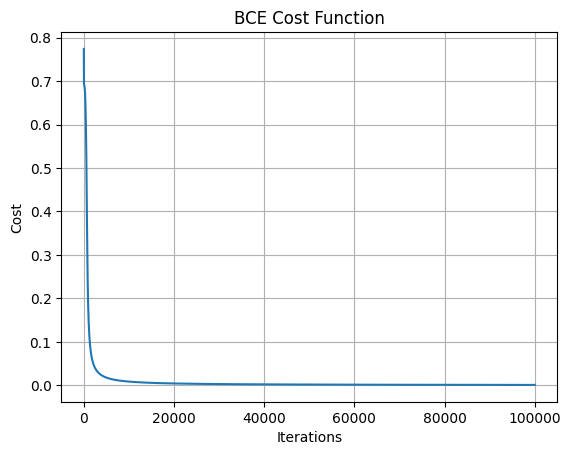

In [1]:
import numpy as np
from matplotlib import pyplot as plt

class MLP():

    """
    This is the MLP class used to feedforward and backpropagate the network across a defined number
    of iterations and produce predictions. After iteration the predictions are assessed using
    Binary Cross Entropy Cost function.
    """

    print('Running...')

    def __init__(self, design_matrix, Y, iterations=100000, lr=1e-1, input_layer = 2, hidden_layer = 3,output_layer =1):
        self.design_matrix = design_matrix #design matrix attibute
        self.iterations = iterations #iterations attibute
        self.lr = lr #learning rate attibute
        self.input_layer = input_layer #input layer attibute
        self.hidden_layer = hidden_layer #hidden layer attibute
        self.output_layer = output_layer #output layer attibute
        self.weight_matrix_1 = np.random.randn(self.input_layer, self.hidden_layer) #weight attribute connecting to the hidden layer
        self.weight_matrix_2 = np.random.randn(self.hidden_layer, self.output_layer)#weight attribute connecting to the output layer
        self.cost = [] #cost list attribute
        self.p_hats = [] #predictions list attribute

    def sigmoid(self, x): # sigmoid function used at the hidden layer and output layer
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x): # sigmoid derivative used for backpropgation
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def forward_propagation(self):#define function to feedforward the network
        z = np.dot(self.design_matrix, self.weight_matrix_1) #linear transformation to the hidden layer
        activation_func = self.sigmoid(z)#hidden layer activation function
        zh = np.dot(activation_func, self.weight_matrix_2)#linear transformation to the output layer
        p_hat = self.sigmoid(zh)#output layer prediction
        return z, activation_func, zh, p_hat

    def BCECost(self, y, p_hat): # binary cross entropy cost function
        bce_cost = -(np.sum(y * np.log(p_hat) + (1 - y) * np.log(1 - p_hat))) / len(y)
        return bce_cost

    def backword_prop(self, z_1, activation_func, z_2, p_hat): #backpropagation
        del_2_1 = p_hat - Y
        partial_deriv_2 = np.dot(activation_func.T, del_2_1) #∂loss/∂p *∂p/∂zh * ∂zh/∂wh
        del_1_1 = del_2_1
        del_1_2 = np.multiply(del_1_1, self.weight_matrix_2.T)
        del_1_3 = np.multiply(del_1_2, self.sigmoid_derivative(z_1))
        partial_deriv_1 = np.dot(self.design_matrix.T, del_1_3) #∂loss/∂p * ∂p/∂zh * ∂zh/∂h * ∂h/∂z * ∂z/∂w
        return partial_deriv_2, partial_deriv_1

    def train(self):#train the network
        for i in range(self.iterations): #loop based on number of iterations
            z_1, activation_func, z_2, p_hat = self.forward_propagation()# feedforward
            partial_deriv_2, partial_deriv_1 = self.backword_prop(z_1, activation_func, z_2, p_hat)#backpropgate
            self.weight_matrix_1 = self.weight_matrix_1 - self.lr * partial_deriv_1#update weights connecting to the hidden layer (gradient descent)
            self.weight_matrix_2 = self.weight_matrix_2 - self.lr * partial_deriv_2#update weights connecting to the output layer (gradient descent )
            self.cost.append(self.BCECost(Y, p_hat))#store BCE cost in list
            self.p_hats.append(p_hat)#store predictions in list


        print('Training Complete')
        print('----------------------------------------------------------------------------')

# Prepare the XOR Logic Gate data: create an array for each training example x feature, and an array for each corrosponding y label.
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]]) #input features (4 x 2 design matrix)
Y = np.array([[1], [1], [0], [0]])#ground truth y labels (4x1)

mlp = MLP(X,Y)#Pass data to the model (design matrix and y label)
mlp.train() #Train the model

#plot the cost function
plt.grid()
plt.plot(range(mlp.iterations),mlp.cost)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('BCE Cost Function')

#Print predictions, number of iterations and the ground truth labels.
print(f'\n The MLP predictions for each training example, based on {mlp.iterations} iterations are:\n\n{np.round(mlp.p_hats[-1],2)}')
print('\n----------------------------------------------------------------------------')
print(f'\n The ground truth Y labels are are:\n\n{Y}')
